In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

%matplotlib inline

2022-11-17 02:14:47.093479: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


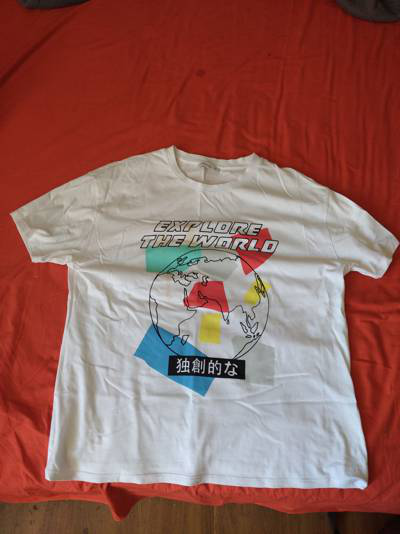

In [2]:
path = '/home/jovyan/clothing-dataset-small/train/t-shirt/'
name = '00003aeb-ace5-43bf-9a0c-dc31a03e9cd2.jpg'

fullname = f'{path}/{name}'
load_img(fullname)

In [3]:
img = load_img(fullname, target_size=(299, 299))

In [4]:
print(img)

<PIL.Image.Image image mode=RGB size=299x299 at 0x7F3B970533A0>


In [5]:
x = np.array(img)
x.shape

(299, 299, 3)

## 8.3 Pre-trained CNNs

* imagenet dataset: https://www.image-net.org/
* Pre-trained models: https://keras.io/api/applications/

In [6]:
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions

model = Xception(weights='imagenet', input_shape=(299, 299, 3))

2022-11-17 02:15:04.695871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 02:15:04.705127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 02:15:04.705886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 02:15:04.707057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [7]:
X = np.array([x])
X = preprocess_input(X)

In [8]:
pred = model.predict(X)
pred.shape

2022-11-17 02:15:10.372684: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-17 02:15:11.104246: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-17 02:15:11.104965: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-17 02:15:11.105007: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-17 02:15:11.105625: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-17 02:15:11.105749: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 3s 3s/step


(1, 1000)

In [9]:
decode_predictions(pred) 

[[('n03595614', 'jersey', 0.88693106),
  ('n02730930', 'apron', 0.006279675),
  ('n04235860', 'sleeping_bag', 0.0059950864),
  ('n04456115', 'torch', 0.005802477),
  ('n03710637', 'maillot', 0.0057547335)]]

## 8.5 Transfer Learning
* Reading data with `ImageDataGenerator`
* Train Xception on smaller images (150x150)

(Better to run it with a GPU)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [12]:
train_ds = train_gen.flow_from_directory(
    '/home/jovyan/clothing-dataset-small/train/', 
    target_size=(150, 150), 
    batch_size=32
)

Found 3068 images belonging to 10 classes.


In [41]:
X, y = next(train_ds)

In [42]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [43]:
y[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [44]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    '/home/jovyan/clothing-dataset-small/validation/',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 341 images belonging to 10 classes.


### Layers
Inputs(150x150x32) --> Base(32_batchx55x2048) --> Vectors(32x2048) --> Outputs(32x10)

In [62]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

In [63]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

In [64]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [65]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 15s 136ms/step - loss: 1.3313 - accuracy: 0.6662 - val_loss: 0.7153 - val_accuracy: 0.8006
Epoch 2/10
96/96 [==============================] - 12s 123ms/step - loss: 0.5871 - accuracy: 0.8139 - val_loss: 0.9533 - val_accuracy: 0.7683
Epoch 3/10
96/96 [==============================] - 12s 123ms/step - loss: 0.3031 - accuracy: 0.8973 - val_loss: 0.8661 - val_accuracy: 0.7830
Epoch 4/10
96/96 [==============================] - 12s 124ms/step - loss: 0.2166 - accuracy: 0.9237 - val_loss: 0.8569 - val_accuracy: 0.7830
Epoch 5/10
96/96 [==============================] - 12s 124ms/step - loss: 0.1699 - accuracy: 0.9400 - val_loss: 0.8259 - val_accuracy: 0.8094
Epoch 6/10
96/96 [==============================] - 12s 123ms/step - loss: 0.1189 - accuracy: 0.9547 - val_loss: 0.8507 - val_accuracy: 0.8094
Epoch 7/10
96/96 [==============================] - 12s 123ms/step - loss: 0.0781 - accuracy: 0.9769 - val_loss: 0.8362 - val_accuracy: 0.8065

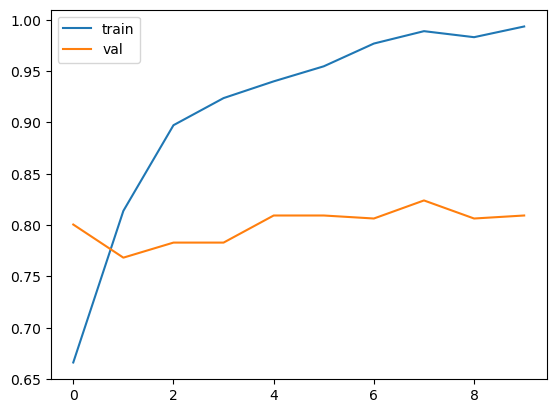

In [67]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')

plt.legend()